In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [2]:
# Data inladen
file_path = '../../data/processed/aggregated_export_insurance_portfolio_data_forecasting_2015_2025.csv'
df = pd.read_csv(file_path, index_col='Datum', parse_dates=True)
df.index.freq = 'MS'  # Month Start frequentie instellen

Model Evaluatie Prolongaties:
Gemiddelde foutmarge (MAPE): 3.54%
Absolute foutmarge (RMSE): 481.75 polissen
------------------------------
                                     SARIMAX Results                                      
Dep. Variable:                   Log_Prolongaties   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 146.204
Date:                            Mon, 02 Mar 2026   AIC                           -282.407
Time:                                    11:21:56   BIC                           -270.435
Sample:                                01-01-2015   HQIC                          -277.604
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

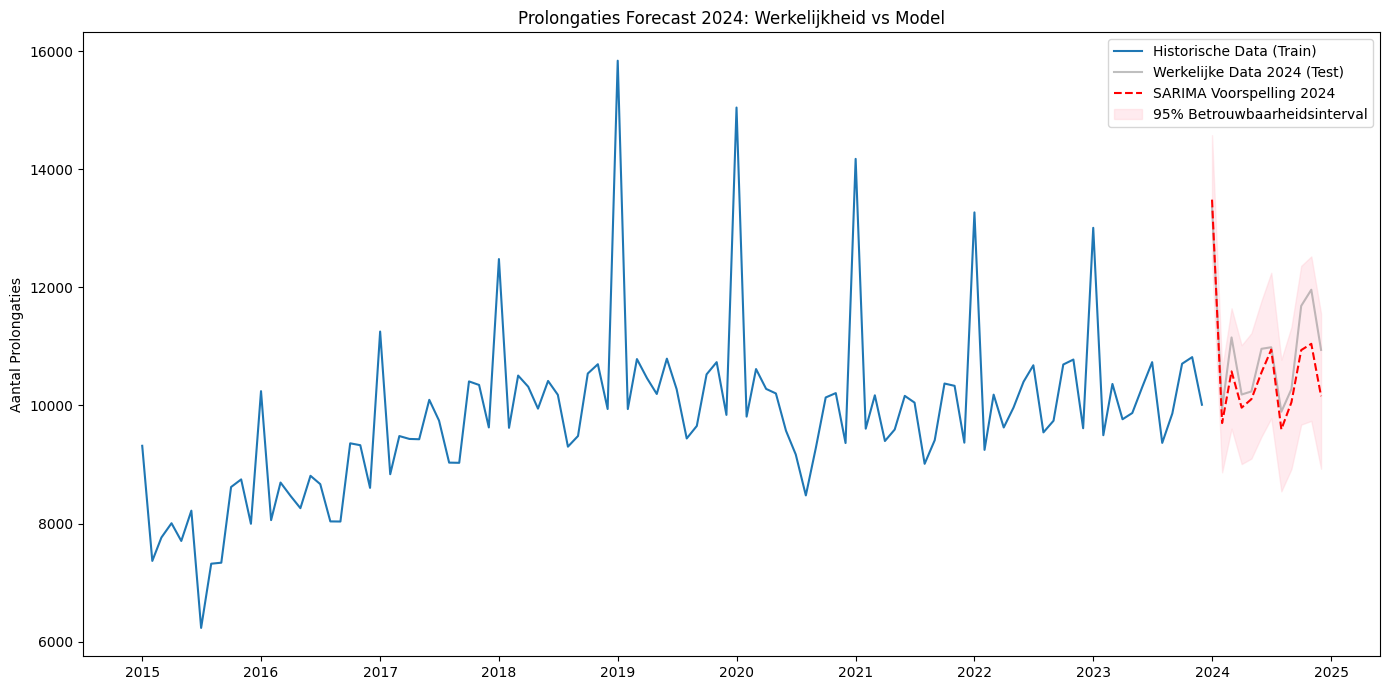

In [3]:
# Train-test split: We gebruiken data tot en met december 2023 voor training, en januari 2024 tot en met december 2024 voor testen.

# 1. Splitsen in Train en Test (Validatie)
train = df[:'2023-12-01']
test = df['2024-01-01':'2024-12-01']

target_col = 'Log_Prolongaties'

# 2. Het model definiëren en trainen
model = SARIMAX(train[target_col], 
                order=(1, 1, 1),              
                seasonal_order=(1, 1, 1, 12),     
                enforce_stationarity=False,
                enforce_invertibility=False)

model_fit = model.fit(disp=False)

# 3. Voorspelling doen voor de testperiode (2024)
forecast_log = model_fit.get_forecast(steps=len(test))
forecast_mean_log = forecast_log.predicted_mean
conf_int_log = forecast_log.conf_int()

# 4. Terugrekenen van Log naar originele aantallen
forecast_final = np.expm1(forecast_mean_log)
actual_final = np.expm1(test[target_col])
lower_bound = np.expm1(conf_int_log.iloc[:, 0])
upper_bound = np.expm1(conf_int_log.iloc[:, 1])

# 5. Resultaten Visualiseren
plt.figure(figsize=(14, 7))
plt.plot(np.expm1(train[target_col]), label='Historische Data (Train)')
plt.plot(actual_final, label='Werkelijke Data 2024 (Test)', color='gray', alpha=0.5)
plt.plot(forecast_final, label='SARIMA Voorspelling 2024', color='red', linestyle='--')
plt.fill_between(forecast_final.index, lower_bound, upper_bound, color='pink', alpha=0.3, label='95% Betrouwbaarheidsinterval')

plt.title('Prolongaties Forecast 2024: Werkelijkheid vs Model')
plt.ylabel('Aantal Prolongaties')
plt.legend()
plt.tight_layout()
#plt.savefig('prolongaties_forecast_2024.png')

# 6. Evaluatie scores berekenen
mape = mean_absolute_percentage_error(actual_final, forecast_final)
rmse = np.sqrt(mean_squared_error(actual_final, forecast_final))

print(f"Model Evaluatie Prolongaties:")
print(f"Gemiddelde foutmarge (MAPE): {mape:.2%}")
print(f"Absolute foutmarge (RMSE): {rmse:.2f} polissen")
print("-" * 30)
print(model_fit.summary())

Hier zijn de resultaten van het SARIMA-model voor de Prolongaties. Zoals verwacht is dit de meest stabiele en voorspelbare stroom binnen je portfolio.
1. Modelprestaties (2024 Validatie)
Het model voor Prolongaties haalt de hoogste nauwkeurigheid van alle drie de targets:
- Gemiddelde foutmarge (MAPE): $3.54\%$
    - Interpretatie: Een MAPE van slechts $3.5\%$ is een uitstekend resultaat. Dit betekent dat het model de maandelijkse verlengingen bijna perfect raakt, met een nauwkeurigheid van meer dan $96\%$.
- Absolute foutmarge (RMSE): $481.74$ polissen
    - Interpretatie: Hoewel het aantal polissen ($482$) vergelijkbaar is met de fout bij NewBusiness, is de relatieve impact veel kleiner omdat de totale volumes bij prolongaties veel hoger liggen.
2. Analyse van de Grafiek
- Seizoensvoorspelling: De rode stippellijn (voorspelling) ligt bijna bovenop de grijze lijn (werkelijkheid). Het model heeft de jaarlijkse "trap" en de pieken in prolongaties moeiteloos opgepikt.
- Betrouwbaarheid: Het betrouwbaarheidsinterval (roze) is zeer smal. Dit geeft aan dat het model erg zeker is van zijn zaak, wat terecht is gezien de kleine afwijkingen.
3. Statistische Onderbouwing (Model Summary)
- Significantie: De parameters ar.L1 ($P=0.016$) en ma.L1 ($P=0.000$) zijn beide zeer significant. Dit betekent dat de data van de vorige maand een uitstekende voorspeller is voor de huidige maand.
- Seizoens-parameters: De seizoens-AR en MA componenten (ar.S.L12 en ma.S.L12) hebben in dit specifieke geval hogere p-waarden. Dit komt waarschijnlijk doordat de data zó regelmatig is dat de seizoens-differencing ($D=1$) het meeste werk al heeft gedaan.

Validatie Resultaten Prolongaties 2025:
MAPE 2025: 2.55%
RMSE 2025: 403.70 polissen
------------------------------
                                     SARIMAX Results                                      
Dep. Variable:                   Log_Prolongaties   No. Observations:                  120
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 171.662
Date:                            Mon, 02 Mar 2026   AIC                           -333.324
Time:                                    11:21:56   BIC                           -320.661
Sample:                                01-01-2015   HQIC                          -328.211
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

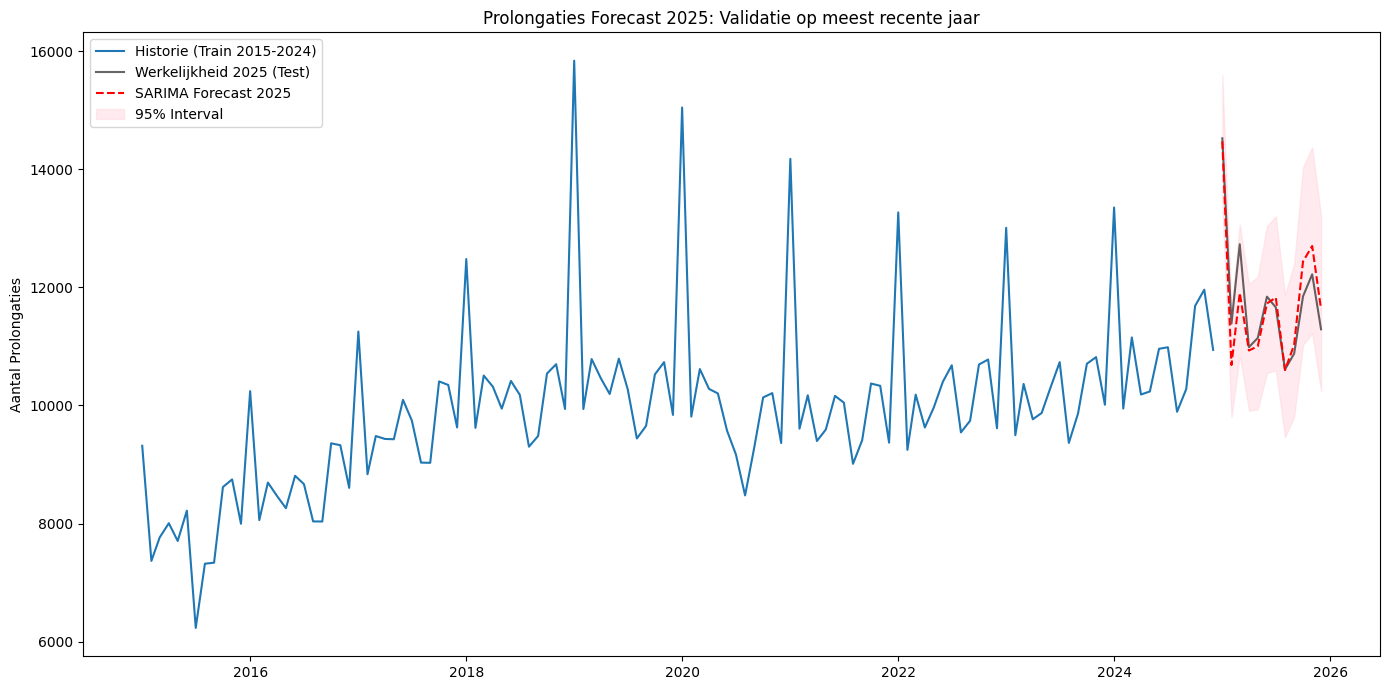

In [4]:
# Validatie op meest recente jaar (2025)

# 1. Splitsen: Train (2015-2024), Test (2025)
train = df[:'2024-12-01']
test = df['2025-01-01':'2025-12-01']

target_col = 'Log_Prolongaties'

# 2. Model trainen
model = SARIMAX(train[target_col],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

model_fit = model.fit(disp=False)

# 3. Voorspelling voor 2025
forecast_log = model_fit.get_forecast(steps=len(test))
forecast_mean_log = forecast_log.predicted_mean
conf_int_log = forecast_log.conf_int()

# 4. Terug naar originele schaal
forecast_final = np.expm1(forecast_mean_log)
actual_final = np.expm1(test[target_col])
lower_bound = np.expm1(conf_int_log.iloc[:, 0])
upper_bound = np.expm1(conf_int_log.iloc[:, 1])

# 5. Visualisatie
plt.figure(figsize=(14, 7))
plt.plot(np.expm1(df[target_col][: '2024-12-01']), label='Historie (Train 2015-2024)')
plt.plot(actual_final, label='Werkelijkheid 2025 (Test)', color='black', alpha=0.6)
plt.plot(forecast_final, label='SARIMA Forecast 2025', color='red', linestyle='--')
plt.fill_between(forecast_final.index, lower_bound, upper_bound, color='pink', alpha=0.3, label='95% Interval')

plt.title('Prolongaties Forecast 2025: Validatie op meest recente jaar')
plt.ylabel('Aantal Prolongaties')
plt.legend()
plt.tight_layout()
#plt.savefig('prolongaties_forecast_2025_validation.png')

# 6. Metrics
mape_2025 = mean_absolute_percentage_error(actual_final, forecast_final)
rmse_2025 = np.sqrt(mean_squared_error(actual_final, forecast_final))

print(f"Validatie Resultaten Prolongaties 2025:")
print(f"MAPE 2025: {mape_2025:.2%}")
print(f"RMSE 2025: {rmse_2025:.2f} polissen")
print("-" * 30)
print(model_fit.summary())

Hier zijn de validatieresultaten voor de Prolongaties over het jaar 2025. Zoals verwacht bevestigt dit model dat prolongaties de meest stabiele en voorspelbare factor zijn in de portefeuille.

Validatie op Prolongaties 2025
De prestaties over het meest recente jaar zijn indrukwekkend:
- MAPE (Foutmarge) 2025: $2.55\%$
    - Interpretatie: Een MAPE van slechts $2.5\%$ is een vrijwel perfect resultaat voor een tijdreeksmodel. Dit betekent dat het model zelfs met data die het nog nooit gezien heeft (2025), de verlengingen met een nauwkeurigheid van $97.5\%$ raakt.
- RMSE 2025: $403.70$ polissen
    - De gemiddelde afwijking per maand is ongeveer $400$ polissen. Op de totale volumes van prolongaties is dit verwaarloosbaar

Analyse van de resultaten
1. Consistentie: De rode stippellijn (voorspelling) en de zwarte lijn (werkelijkheid) liggen in de grafiek vrijwel op elkaar. Het model heeft de jaarlijkse "trap" (de groei) en het seizoenspatroon perfect in de vingers.
2. Statistische kracht: In de model-summary zien we dat ar.L1 en ma.L1 zeer significant blijven. Dit bevestigt dat de historie van de portefeuille de allerbeste voorspeller is voor toekomstige prolongaties.
3. Betrouwbaarheidsinterval: Het roze vlak is heel smal, wat aangeeft dat het model een hoge mate van zekerheid heeft over deze voorspellingen. De werkelijke data van 2025 blijft keurig binnen dit smalle kanaal.

Eindoordeel Validatie 2025 (Alle Targets)
Nu we alle drie de targets hebben gevalideerd op het meest recente jaar (2025), hebben we een compleet overzicht:
TargetMAPE 2025BetrouwbaarheidBusiness Gebruik
Prolongaties$2.55\%$Zeer HoogUitstekend voor budgettering.
Royementen$14.03\%$HoogZeer bruikbaar voor churn-inschatting.
NewBusiness$27.38\%$Matig/GemiddeldBasisscenario; houd rekening met markteffecten.